In [1]:
import requests
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import inv, solve, det

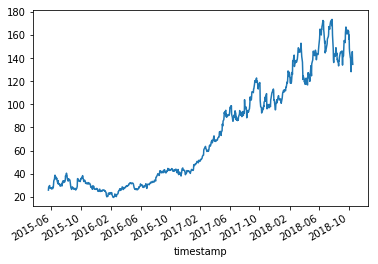

In [2]:
# Load data
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SHOP&outputsize=full&apikey=83SCGSM1BQW0WE86&datatype=csv'
source = requests.get(url).content.decode().split("\n")
df = pd.read_csv(url, index_col=0, parse_dates=True)
df.to_csv('SHOPprices.csv')
df['close'].plot() 
plt.show()

In [2]:
## Load dataset obtained earlier

df = pd.read_csv('SHOPprices.csv', index_col=0, parse_dates=True)

## LPPLS estimates

# Definitions

df['const'] = 1
df['t'] = list(reversed(range(len(df['const']))))
tc = len(df['const'])+1
m = 0.5
ω = 10

const = np.array(df['const'])
x0 = np.array([tc,m,ω])
t = np.array(df['t'])
p = np.array(df['close']).T
y = np.log(p)

def f(x0, t):
    return x0[0] - t**x0[1]

def g(x0, t):
    return ((x0[0]-t)**x0[1])*np.cos(x0[2]*np.log(x0[0]-t))
               
def h(x0,t):
    return ((x0[0]-t)**x0[1])*np.sin(x0[2]*np.log(x0[0]-t))

def X(const, x0, t):
    return np.array([const, f(x0,t), g(x0,t), h(x0,t)]).T

def β_hat(const, x0, t):
    return inv(X(const, x0, t).T @ X(const, x0, t)) @ X(const, x0, t).T @ y

def residual(const, x0, t):
    
    A_hat = const*β_hat(const,x0,t)[0]
    B_hat = β_hat(const,x0,t)[1]
    C_1_hat = β_hat(const,x0,t)[2]
    C_2_hat = β_hat(const,x0,t)[3]
    
    return y - A_hat - B_hat*f(x0,t) - C_1_hat*g(x0,t) - C_2_hat*h(x0,t)

## Non-linear least squares

# Approximating the Jacobian via finite differences

δ = 0.0001 #adjustable perturbation

tc_perturb_plus = np.array([tc+δ,m,ω])
tc_perturb_minus = np.array([tc-δ,m,ω])
m_perturb_plus = np.array([tc,m+δ,ω])
m_perturb_minus = np.array([tc,m-δ,ω])
ω_perturb_plus = np.array([tc,m,ω+δ])
ω_perturb_minus = np.array([tc,m,ω-δ])

def J(const, x0, t):
    
    tc_dev = (residual(const, tc_perturb_plus, t) - residual(const, tc_perturb_minus, t)) / 2*δ
    m_dev = (residual(const, m_perturb_plus, t) - residual(const, m_perturb_minus, t)) / 2*δ
    ω_dev = (residual(const, ω_perturb_plus, t) - residual(const, ω_perturb_minus, t)) / 2*δ
    
    return np.array([tc_dev, m_dev, ω_dev]).T

# Levenberg-Marquardt algorithm

def LM(const, x0, t):
    
    iterations = 100 # adjust this as needed
    λ = 1 # initial damping parameter
    ssr0 = (residual(const, x0, t)**2).sum() # initial sum of squared residuals
    i =0

    while i<iterations:
        x1 = x0 - (inv(J(const, x0, t).T @ J(const, x0, t) + λ*np.identity(3)) @ J(const, x0, t).T @ residual(const, x0, t)) # tentative iterate
        ssr1 = (residual(const, x1, t)**2).sum()
        if ssr1 < ssr0:
            λ = 0.8*λ
            x0 = x1
            ssr0 = ssr1
            i = i+1
        else:
            λ = 2*λ
            ssr0 = ssr1
            
    return np.array([β_hat(const,x0,t), x0, ssr0])  #Estimates of A_hat, B_hat, C_1_hat, C_2_hat, tc, m, ω and SSR

x0_LM = LM(const,x0,t)[1]

In [3]:
# Fitting curves to groups of past windows

data = pd.read_csv('SHOPprices.csv', parse_dates=True) # load master data

dstore = pd.DataFrame(columns=['A_hat','B_hat','C_1_hat','C_2_hat','tc','m','ω']) # a place to store results

for i in range(30,121): # 30,121 took 3m 21s to run
    
    # Takes the relevant dates
    
    df = data.head(i).copy()
    
    # LPPLS estimates (recomputing some things to be safe)
    
    df['const'] = 1
    df['t'] = list(reversed(range(len(df['const']))))

    tc = len(df['const'])+1
    m = 0.5
    ω = 10

    const = np.array(df['const'])
    x0 = np.array([tc,m,ω])
    t = np.array(df['t'])
    p = np.array(df['close']).T
    y = np.log(p)
    
    tc_perturb_plus = np.array([tc+δ,m,ω])
    tc_perturb_minus = np.array([tc-δ,m,ω])
    m_perturb_plus = np.array([tc,m+δ,ω])
    m_perturb_minus = np.array([tc,m-δ,ω])
    ω_perturb_plus = np.array([tc,m,ω+δ])
    ω_perturb_minus = np.array([tc,m,ω-δ])

    x0_LM = LM(const,x0,t)[1]

    # Store results w index 1

    dstore.loc[i, ['A_hat']] = β_hat(const,x0_LM,t)[0]
    dstore.loc[i, ['B_hat']] = β_hat(const,x0_LM,t)[1]
    dstore.loc[i, ['C_1_hat']] = β_hat(const,x0_LM,t)[2]
    dstore.loc[i, ['C_2_hat']] = β_hat(const,x0_LM,t)[3]
    dstore.loc[i, ['tc']] = x0_LM[0]
    dstore.loc[i, ['m']] = x0_LM[1]
    dstore.loc[i, ['ω']] = x0_LM[2]

In [5]:
## Computing confidence indicators (positive bubbles only, initial run)

# Criteria from Demos, Zhang, and Sornette (2017) - uses a simplified tc one (I don't understand the full one)

# Damping parameter D

dstore['D'] = (dstore['m']*abs(dstore['B_hat']))/((dstore['ω']*(dstore['C_1_hat']**2+dstore['C_2_hat']**2))**(0.5))

# Oscillations parameter O

# pre-condition for O

dstore['C/B'] = (((dstore['C_1_hat']**2+dstore['C_2_hat']**2))**(0.5))/abs(dstore['B_hat'])

# O parameter

dstore['tempindex'] = dstore.index.astype(float)
dstore['tc'] = dstore['tc'].astype(float)
dstore['O'] = (dstore['ω']/math.pi)*(np.log(dstore['tc']/(dstore['tc']-dstore['tempindex'])))
del dstore['tempindex']

# O parameter check

dstore['O_check'] = np.where((dstore['C/B']>=0.05) & (dstore['O']<2.5), 0, 1)

# Overall criteria check

dstore['criteria'] = np.where((dstore['B_hat'] <0) & (dstore['m'] >0) & (dstore['m'] <1) & (dstore['ω'] >=4) & (dstore['ω'] <=25) & (dstore['tc'] >0) & (dstore['D'] >=0.5) & (dstore['O_check'] ==1),1, 0)

# % of qualified fits for this date

dstore['LPPLSConf'] = dstore['criteria'].sum()/91

# Capture summary statistics

comp = "Shopify" # company - adjusted manually for now
esttime = data.index[0] # time when estimates are run
LPPLSconf = dstore['criteria'].sum()/91 # LPPLS Confidence Indicator

# Store in a detector dataset (a loop will populate this for different days)

detector = pd.DataFrame(columns=['Company', 'Estimation Date', 'Close', 'Vol', 'LPPLS Confidence'])

detector.loc[0, ['Company']] = comp
detector.loc[0, ['Estimation Date']] = data['timestamp'][0]
detector.loc[0, ['Close']] = data['close'][0]
detector.loc[0, ['Vol']] = data['volume'][0]
detector.loc[0, ['LPPLS Confidence']] = LPPLSconf

detector.head()

,Company,Estimation Date,Close,Vol,LPPLS Confidence
0,Shopify,2018-10-18,134.78,1595355,0.164835


In [24]:
## loop which adds more days to the 'detector' dataset

j = 41
runs = 51 

while j<runs:
    data = pd.read_csv('SHOPprices.csv', parse_dates=True) # load master data
    data = data.iloc[j:]
    
    try:
        for i in range(30,121):

            df = data.head(i).copy()

            df['const'] = 1
            df['t'] = list(reversed(range(len(df['const']))))

            tc = len(df['const'])+1
            m = 0.5
            ω = 10

            const = np.array(df['const'])
            x0 = np.array([tc,m,ω])
            t = np.array(df['t'])
            p = np.array(df['close']).T
            y = np.log(p)

            tc_perturb_plus = np.array([tc+δ,m,ω])
            tc_perturb_minus = np.array([tc-δ,m,ω])
            m_perturb_plus = np.array([tc,m+δ,ω])
            m_perturb_minus = np.array([tc,m-δ,ω])
            ω_perturb_plus = np.array([tc,m,ω+δ])
            ω_perturb_minus = np.array([tc,m,ω-δ])

            x0_LM = LM(const,x0,t)[1]

            dstore.loc[i, ['A_hat']] = β_hat(const,x0_LM,t)[0]
            dstore.loc[i, ['B_hat']] = β_hat(const,x0_LM,t)[1]
            dstore.loc[i, ['C_1_hat']] = β_hat(const,x0_LM,t)[2]
            dstore.loc[i, ['C_2_hat']] = β_hat(const,x0_LM,t)[3]
            dstore.loc[i, ['tc']] = x0_LM[0]
            dstore.loc[i, ['m']] = x0_LM[1]
            dstore.loc[i, ['ω']] = x0_LM[2]

        dstore['D'] = (dstore['m']*abs(dstore['B_hat']))/((dstore['ω']*(dstore['C_1_hat']**2+dstore['C_2_hat']**2))**(0.5))

        dstore['C/B'] = (((dstore['C_1_hat']**2+dstore['C_2_hat']**2))**(0.5))/abs(dstore['B_hat'])

        dstore['tempindex'] = dstore.index.astype(float)
        dstore['tc'] = dstore['tc'].astype(float)
        dstore['O'] = (dstore['ω']/math.pi)*(np.log(dstore['tc']/(dstore['tc']-dstore['tempindex'])))
        del dstore['tempindex']

        dstore['O_check'] = np.where((dstore['C/B']>=0.05) & (dstore['O']<2.5), 0, 1)

        dstore['criteria'] = np.where((dstore['B_hat'] <0) & (dstore['m'] >0) & (dstore['m'] <1) & (dstore['ω'] >=4) & (dstore['ω'] <=25) & (dstore['tc'] >0) & (dstore['D'] >=0.5) & (dstore['O_check'] ==1),1, 0)

        dstore['LPPLSConf'] = dstore['criteria'].sum()/91
        
        LPPLSconf = dstore['criteria'].sum()/91
    except:
        LPPLSconf = 101
    
    comp = "Shopify"
    esttime = data.index[j]

    detector.loc[j, ['Company']] = comp
    detector.loc[j, ['Estimation Date']] = data['timestamp'][j]
    detector.loc[j, ['Close']] = data['close'][j]
    detector.loc[j, ['Vol']] = data['volume'][j]
    detector.loc[j, ['LPPLS Confidence']] = LPPLSconf

    j = j + 1

detector

C:\Users\hubert.wu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log


,Company,Estimation Date,Close,Vol,LPPLS Confidence
0,Shopify,2018-10-18,134.78,1595355,0.164835
24,Shopify,2018-09-14,154.77,1247034,101
25,Shopify,2018-09-13,155.5,1259799,101
1,Shopify,2018-10-17,137.37,3149047,0.186813
2,Shopify,2018-10-16,145.83,1391090,0.175824
3,Shopify,2018-10-15,135.7,1114240,0.164835
4,Shopify,2018-10-12,135.2,2034632,0.175824
5,Shopify,2018-10-11,128.39,2076005,0.175824
6,Shopify,2018-10-10,130.1,2686349,0.142857
7,Shopify,2018-10-09,140.22,1055758,0.153846


In [20]:
detector.tail()

,Company,Estimation Date,Close,Vol,LPPLS Confidence
29,Shopify,2018-09-07,140.64,2039504,0
30,Shopify,2018-09-06,134.13,1825445,0
31,Shopify,2018-09-05,139.97,2362643,0
32,Shopify,2018-09-04,146.34,912133,0
33,Shopify,2018-08-31,145.67,669084,0


In [23]:
detector.to_csv('detectorSHOP.csv')
dstore.to_csv('dstoreSHOP.csv')

In [11]:
# Use this to identify bubble areas for a desired set of dates

df = pd.read_csv('SHOPprices.csv', index_col=0, parse_dates=True)
df['const'] = 1
df['j'] = range(len(df['const']))

# Type in the date ranges you want and then enter the 'j' in the loop above

# Example: df['2018-10-31':'2018-10-15']